In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../source/

/home/ivan/HD/ivan/dev/pigs/source


In [28]:
from PIL import Image
import _pigs as piglib
from pigs import Pigs 
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage import sobel

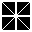

In [29]:
image = Image.open('../data/test.png')
# image = Image.open('../data/flower.jpg')
# image = Image.open('pigs.jpg')

image

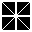

In [30]:
# im_size = (2**6, 2**6)
m = 5
im_size = (2**m, 2**m)
image_ = image.resize(im_size, )
image_

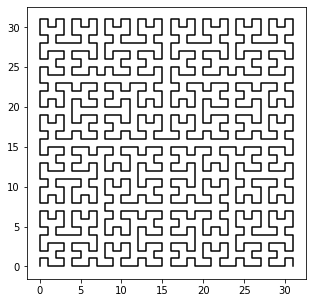

In [31]:
import numpy as np
from hilbert import decode, encode
# m = 3
locs = decode(np.arange(2**m*2**m), 2, m).astype(np.int)

plt.figure(figsize=(5,5))
plt.plot(locs[:,0], locs[:,1], 'k')

In [32]:
'''Hilbert flattenning'''
ndarray_image = np.array(image_).astype(int) #/ 255
# ndarray_sobel = sobel(ndarray_image, axis=1)

flatted_image = ndarray_image[locs[:,0], locs[:,1]]
# flatted_sobel = ndarray_sobel[locs[:,0], locs[:,1]]
flatted_image.shape

(1024, 3)

In [33]:
def rgb_pos_kernel(rgb1,rgb2,pos1,pos2,N,beta):
    pos = abs((pos1[0] - pos2[0]) + (pos1[1] - pos2[1])) / (2*N) 
    l2 = np.sqrt((rgb1[0] - rgb2[0] + pos)**2 + 
                 (rgb1[1] - rgb2[1] + pos)**2 + 
                 (rgb1[2] - rgb2[2] + pos)**2)
    result = np.exp(-beta * l2)

    return result

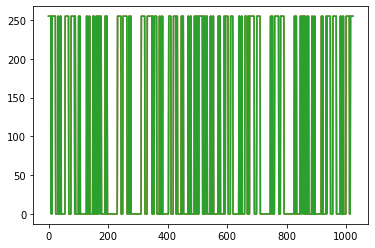

In [34]:
plt.plot(flatted_image)
plt.show()

In [35]:
%%time
N = flatted_image.shape[0]
beta = 1/20#13.2#50

G = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if i > j: #and abs(i-j) < N//3:
            i1 = flatted_image[i]
            j2 = flatted_image[j]
            i_point = (locs[i,0],locs[i,1])
            j_point = (locs[j,0],locs[j,1])
            G[i,j] = rgb_pos_kernel(i1, j2, 
                                    i_point ,j_point, # hilbert flattening
                                    N, beta*2)
G += G.T
for i in range(N): G[i,i]=1

CPU times: user 5.11 s, sys: 5.62 ms, total: 5.12 s
Wall time: 5.12 s


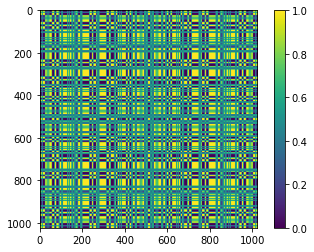

In [48]:
plt.imshow(G)
plt.colorbar()

In [36]:
pig = Pigs(stop=1e-3, verbose=True, beta=1)

In [37]:
%%time
degree, laplace = pig.compute_LD(G)


CPU times: user 4.18 ms, sys: 0 ns, total: 4.18 ms
Wall time: 3.87 ms


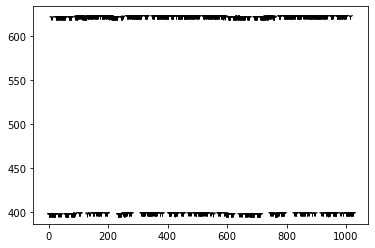

In [38]:
plt.figure()
plt.plot(degree, '1k')
# plt.figure()
# plt.imshow(laplace)
# plt.colorbar()

Root node: 298
CPU times: user 115 ms, sys: 128 ms, total: 243 ms
Wall time: 36.4 ms


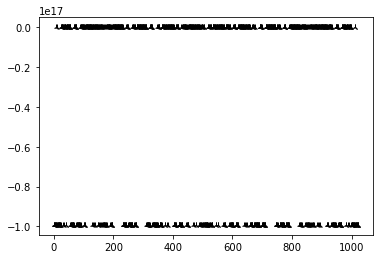

In [39]:
%%time
x, root_node = pig.linear_solver(degree, laplace)
plt.figure()
plt.plot(x, '2k')

In [43]:
%%time
threshold, ir,  irlist = pig.compute_IR_threshold(x, G, degree)
print(threshold, ir )
mask = pig.generate_mask(flatted_image, x, threshold, root_node)

-4962306035648688.0 0.17348443692048
CPU times: user 1.23 s, sys: 0 ns, total: 1.23 s
Wall time: 1.23 s


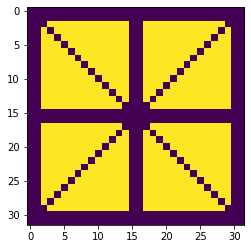

In [44]:
msk = np.zeros(im_size)
for i, pos in enumerate(locs):
    msk[pos[0],pos[1]] = mask[i]
    
# plt.imshow(mask.reshape(im_size))
plt.imshow(msk)

In [45]:
# msk = mask.reshape(im_size)
np_img = np.array(image_)
msk_img = np.zeros_like(np_img)
for i in range(3):
    msk_img[:,:,i] = np.ma.masked_where(msk, np_img[:,:,i])

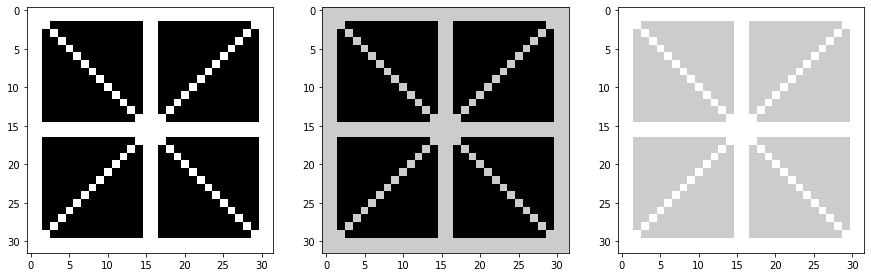

In [46]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(image_)

ax[1].imshow(np_img)
ax[1].imshow(np.ma.masked_where(msk, msk), 'nipy_spectral_r')

msk_ = np.logical_not(msk)
ax[2].imshow(np_img)
ax[2].imshow(np.ma.masked_where(msk_, msk_), 'nipy_spectral_r')



In [47]:
'''NEXT ITERATION'''

'NEXT ITERATION'

In [387]:
mask = np.logical_not(mask)

In [426]:
ids = np.where(mask)[0]

In [427]:
%%time
new_N = len(ids)
new_G = np.zeros((new_N, new_N))
N = flatted_image.shape[0]

for ki, i in enumerate(ids):
    for kj, j in enumerate(ids):
        if ki > kj: #and abs(i-j) < N//3:
            i1 = flatted_image[i]
            j2 = flatted_image[j]
            i_point = (locs[i,0],locs[i,1])
            j_point = (locs[j,0],locs[j,1])
            new_G[ki,kj] = rgb_pos_kernel(i1, j2, 
                                    i_point ,j_point, # hilbert flattening
                                    N, beta*2)
new_G += new_G.T

CPU times: user 3.02 s, sys: 0 ns, total: 3.02 s
Wall time: 3.02 s


In [428]:
new_degree, new_laplace = pig.compute_LD(new_G)
# new_degree = degree[mask]
# new_laplace = laplace[mask][:,mask]
# new_G = G[mask][:,mask]

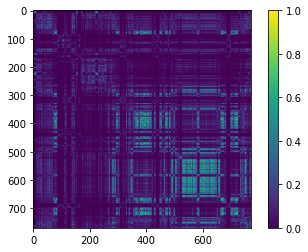

In [429]:
plt.imshow(new_G)
plt.colorbar()

In [430]:
%%time
new_x, new_root_node = pig.linear_solver(new_degree, new_laplace)

Root node: 503
CPU times: user 64.8 ms, sys: 24.2 ms, total: 89 ms
Wall time: 14 ms


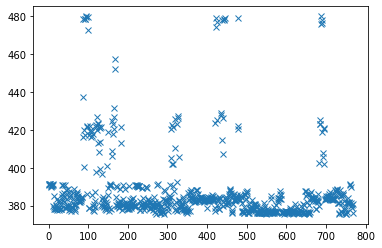

In [431]:
plt.plot(new_x, 'x')

In [432]:
new_x.shape, new_G.shape, new_degree.shape

((769,), (770, 770), (770,))

In [433]:
%%time
new_threshold, new_ir = pig.compute_IR_threshold(new_x, new_G, new_degree)
print(new_threshold, new_ir)

396.52653471283134 0.08123037637163608
CPU times: user 200 ms, sys: 605 µs, total: 201 ms
Wall time: 196 ms


In [434]:
new_mask = pig.generate_mask(flatted_image[mask], new_x, new_threshold, new_root_node)

(1024,) (770,) 1024


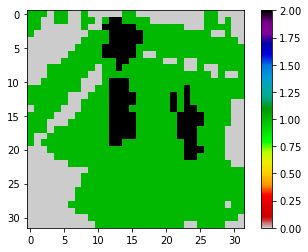

In [435]:
print(mask.shape, new_mask.shape, im_size[0]*im_size[1])
total_mask = np.zeros(im_size[0]*im_size[0], dtype='uint8')
total_mask[mask] = 1
tmp = total_mask[mask]
tmp[new_mask] = 2
total_mask[mask] = tmp

total_mask_img = np.zeros(im_size)
for i, pos in enumerate(locs):
    total_mask_img[pos[0],pos[1]] = total_mask[i]
    
# total_mask_img = total_mask.reshape(im_size)

plt.imshow(total_mask_img, 'nipy_spectral_r')
plt.colorbar()
plt.show()

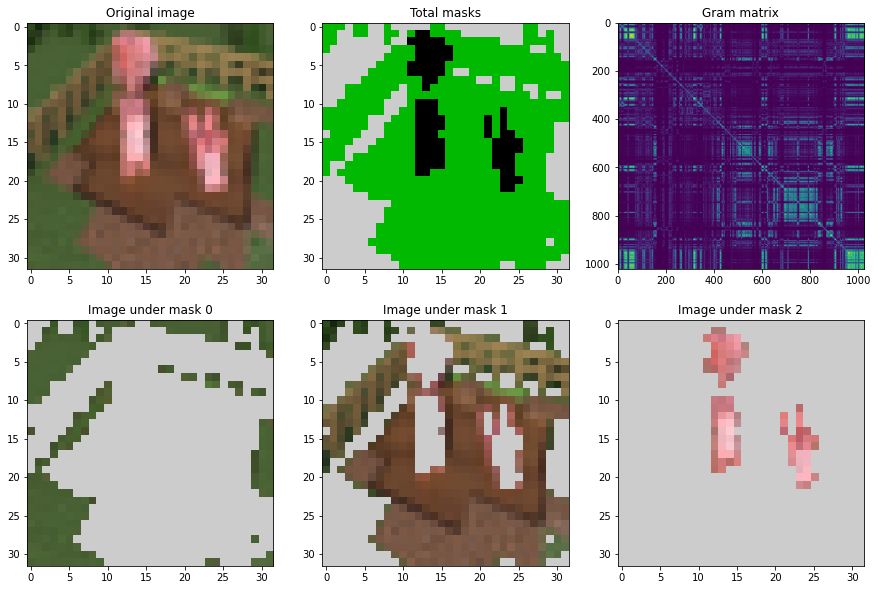

In [436]:
p_mult = 1
fig, ax = plt.subplots(2,3, figsize=(15*p_mult,10*p_mult))#, dpi=1100)

ax[0,0].set_title('Original image')
ax[0,0].imshow(image_)

ax[0,1].set_title('Total masks')
ax[0,1].imshow(total_mask_img, 'nipy_spectral_r')

ax[0,2].set_title('Gram matrix')
ax[0,2].imshow(G)

name = [0,1,2]
for i in [1,2,0]:
    msk = total_mask_img == i
    
    _name = name[i]
    ax[1,i].set_title(f'Image under mask {_name}')
    ax[1,i].imshow(np_img)
    ax[1,i].imshow(np.ma.masked_where(msk, msk), 'nipy_spectral_r')
